<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
#!pip install ydata_profiling

In [2]:
import random
import re
import pickle
from itertools import combinations

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from ydata_profiling import ProfileReport

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

random.seed(42)
np.random.seed(42)


### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

`Your answer here` Сиды фиксируем для воспроизводимости результатов

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [4]:
print('Пропуски в train')
missing_train = df_train.isnull().sum()
print(missing_train[missing_train > 0])

print('Пропуски в test')
missing_test = df_test.isnull().sum()
print(missing_test[missing_test > 0])

cols_with_missing = df_train.columns[df_train.isnull().any()].tolist()
print(f'Колонки с пропусками в train: {cols_with_missing}')

print(f'Дубликаты')
print(f'Дубликатов в train: {df_train.duplicated().sum()}')
print(f'Дубликатов в test: {df_test.duplicated().sum()}')


Пропуски в train
mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64
Пропуски в test
mileage      19
engine       19
max_power    19
torque       19
seats        19
dtype: int64
Колонки с пропусками в train: ['mileage', 'engine', 'max_power', 'torque', 'seats']
Дубликаты
Дубликатов в train: 985
Дубликатов в test: 62


In [5]:
print('Типы данных')
print(df_train.dtypes)

print('Общая информация')
df_train.info()


Типы данных
name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object
Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   objec

**Выводы по базовому EDA:**

1. **Пропуски:** В train-датасете есть пропуски в столбцах `mileage`, `engine`, `max_power`, `torque`, `seats`.

2. **Дубликаты:** В данных присутствуют явные дубликаты

3. **Типы данных:** Столбцы `mileage`, `engine`, `max_power`, `torque` имеют тип object, хотя содержат числовые значения с единицами измерения - требуется преобразование.

4. **Категориальные признаки:** `name`, `fuel`, `seller_type`, `transmission`, `owner` - надо ванхотенкодить.

In [6]:
profile = ProfileReport(df_train, title='Cars Train Dataset EDA')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 450.84it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Выводы по дашборду:**

- **Распределения:** Многие числовые признаки имеют скошенные распределения.
- **Корреляции:** Видны корреляции между selling_price, transmission, year, km_driven.
- **Выбросы:** Присутствуют выбросы в ценах (очень дорогие авто)

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [7]:
# Статистики по числовым столбцам
print('Статистики числовых столбцов - TRAIN')
display(df_train.describe())

print('Статистики числовых столбцов - TEST')
display(df_test.describe())

# Статистики по категориальным столбцам
print('Статистики категориальных столбцов - TRAIN')
display(df_train.describe(include='object'))

print('Статистики категориальных столбцов - TEST')
display(df_test.describe(include='object'))

# Сравнение среднего и медианы
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns
print('Сравнение mean и median')
comparison = pd.DataFrame({
    'train_mean': df_train[numeric_cols].mean(),
    'train_median': df_train[numeric_cols].median(),
    'test_mean': df_test[numeric_cols].mean(),
    'test_median': df_test[numeric_cols].median()
})
comparison['train_diff'] = comparison['train_mean'] - comparison['train_median']
comparison['test_diff'] = comparison['test_mean'] - comparison['test_median']
display(comparison)

Статистики числовых столбцов - TRAIN


year  selling_price     km_driven        seats
count  6999.000000   6.999000e+03  6.999000e+03  6797.000000
mean   2013.818403   6.395152e+05  6.958462e+04     5.419008
std       4.053095   8.089419e+05  5.772400e+04     0.965767
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.700000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

Статистики числовых столбцов - TEST


year  selling_price      km_driven       seats
count  1000.000000   1.000000e+03    1000.000000  981.000000
mean   2013.681000   6.179010e+05   71393.341000    5.410805
std       4.012149   7.585539e+05   48486.218662    0.919985
min    1995.000000   3.100000e+04    1303.000000    4.000000
25%    2011.000000   2.500000e+05   37000.000000    5.000000
50%    2014.000000   4.349990e+05   61500.000000    5.000000
75%    2017.000000   6.700000e+05  100000.000000    5.000000
max    2020.000000   6.000000e+06  375000.000000    9.000000

Статистики категориальных столбцов - TRAIN


name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

Статистики категориальных столбцов - TEST


name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

Сравнение mean и median


train_mean  train_median      test_mean  test_median  \
year             2013.818403        2015.0    2013.681000       2014.0   
selling_price  639515.197171      450000.0  617901.042000     434999.0   
km_driven       69584.615517       60000.0   71393.341000      61500.0   
seats               5.419008           5.0       5.410805          5.0   

                  train_diff      test_diff  
year               -1.181597      -0.319000  
selling_price  189515.197171  182902.042000  
km_driven        9584.615517    9893.341000  
seats               0.419008       0.410805

**Выводы по статистикам:**

1. **Среднее больше медианы** для `selling_price` и `km_driven` - это говорит о правосторонней асимметрии распределения (есть выбросы в большую сторону: дорогие авто и с большим пробегом).

2. **Распределения train и test похожи** - средние и медианы близки между выборками, что говорит о корректном разбиении данных.

3. **Год выпуска:** средний год ~2014, медиана тоже близка - распределение относительно симметричное.

4. **Категориальные признаки:** самый частый тип топлива - Diesel, тип продавца - Individual, трансмиссия - Manual, первый владелец преобладает.

5. **Марки авто:** большое количество уникальных названий (1849 в train) - потребуется группировка или извлечение бренда.


### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [8]:
# Признаковые столбцы (без целевой переменной selling_price)
feature_cols = df_train.columns.drop('selling_price')

# Проверяем дубликаты по признакам
duplicates_mask = df_train.duplicated(subset=feature_cols, keep=False)
num_duplicates = df_train.duplicated(subset=feature_cols, keep='first').sum()
print(f'Объектов с одинаковым признаковым описанием (дубликаты): {num_duplicates}')

# Отображаем дубликаты
print('Дубликаты по признакам:')
duplicated_rows = df_train[duplicates_mask].sort_values(by=list(feature_cols))
display(duplicated_rows.head(20))


Объектов с одинаковым признаковым описанием (дубликаты): 1159
Дубликаты по признакам:


name  year  selling_price  km_driven  \
1703  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
1836               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
6704               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
117             Audi Q5 35TDI Premium Plus  2018        3975000      31800   
1337            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
1595            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
2787            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
4485            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
6640            Audi Q5 35TDI Premium Plus  2018        3975000      31800   
1779         BMW 3 Series 320d Luxury Line  2012        1300000     140000   
1784         BMW 3 Series 320d Luxury Line  2012        1300000     140000   
2886    BMW 3 Series 320d Luxury Line Plus  2017        2600000      44000   
4050    BMW 3 Series 320d Luxury Line Plus  2017        2600000      44000   
1782         BMW 3 Series 320d Luxury Plus  2013        1300000     140000   
1787         BMW 3 Series 320d Luxury Plus  2013        1300000     140000   
3987         BMW 5 Series 520d Luxury Line  2019        5200000      10000   
6687         BMW 5 Series 520d Luxury Line  2019        5200000      10000   
122           BMW 5 Series 520d Sport Line  2018        3790000      29500   
2792          BMW 5 Series 520d Sport Line  2018        3790000      29500   

        fuel seller_type transmission         owner     mileage   engine  \
1703  Diesel      Dealer    Automatic   First Owner  15.73 kmpl  1968 CC   
6307  Diesel      Dealer    Automatic   First Owner  15.73 kmpl  1968 CC   
1836  Diesel  Individual    Automatic   First Owner  13.22 kmpl  2967 CC   
6704  Diesel  Individual    Automatic   First Owner  13.22 kmpl  2967 CC   
117   Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
1337  Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
1595  Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
2787  Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
4485  Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
6640  Diesel      Dealer    Automatic   First Owner  17.01 kmpl  1968 CC   
1779  Diesel  Individual    Automatic  Second Owner  18.88 kmpl  1995 CC   
1784  Diesel  Individual    Automatic  Second Owner  18.88 kmpl  1995 CC   
2886  Diesel      Dealer    Automatic   First Owner  22.69 kmpl  1995 CC   
4050  Diesel      Dealer    Automatic   First Owner  22.69 kmpl  1995 CC   
1782  Diesel  Individual    Automatic  Second Owner  18.88 kmpl  1995 CC   
1787  Diesel  Individual    Automatic  Second Owner  18.88 kmpl  1995 CC   
3987  Diesel      Dealer    Automatic   First Owner  18.12 kmpl  1995 CC   
6687  Diesel      Dealer    Automatic   First Owner  18.12 kmpl  1995 CC   
122   Diesel      Dealer    Automatic   First Owner  22.48 kmpl  1995 CC   
2792  Diesel      Dealer    Automatic   First Owner  22.48 kmpl  1995 CC   

       max_power               torque  seats  
1703  174.33 bhp  380Nm@ 1750-2500rpm    5.0  
6307  174.33 bhp  380Nm@ 1750-2500rpm    5.0  
1836   241.4 bhp  580Nm@ 1400-3250rpm    5.0  
6704   241.4 bhp  580Nm@ 1400-3250rpm    5.0  
117      188 bhp  400nm@ 1750-3000rpm    5.0  
1337     188 bhp  400nm@ 1750-3000rpm    5.0  
1595     188 bhp  400nm@ 1750-3000rpm    5.0  
2787     188 bhp  400nm@ 1750-3000rpm    5.0  
4485     188 bhp  400nm@ 1750-3000rpm    5.0  
6640     188 bhp  400nm@ 1750-3000rpm    5.0  
1779     184 bhp  380Nm@ 1750-2750rpm    5.0  
1784     184 bhp  380Nm@ 1750-2750rpm    5.0  
2886     190 bhp  400Nm@ 1750-2750rpm    5.0  
4050     190 bhp  400Nm@ 1750-2750rpm    5.0  
1782     184 bhp  380Nm@ 1750-2750rpm    5.0  
1787     184 bhp  380Nm@ 1750-2750rpm    5.0  
398

In [9]:
# Удаляем дубликаты, оставляя первую строку
df_train = df_train.drop_duplicates(subset=feature_cols, keep='first')

# Обновляем индексы
df_train = df_train.reset_index(drop=True)

print(f'Размер после удаления дубликатов: {df_train.shape}')

Размер после удаления дубликатов: (5840, 13)


In [10]:
assert df_train.shape == (5840, 13)

**Скрытые дубликаты:**

1. **Нормализация текста** - приведение к нижнему регистру, удаление лишних пробелов, унификация написания

3. **Группировка по ключевым признакам** - например, одинаковый год, пробег, двигатель, но разные названия, особенно если эти названия близки по какой-то метрике

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [11]:
print('Примеры значений:')
print(f"mileage: {df_train['mileage'].dropna().head(3).tolist()}")
print(f"engine: {df_train['engine'].dropna().head(3).tolist()}")
print(f"max_power: {df_train['max_power'].dropna().head(3).tolist()}")
print(f"torque: {df_train['torque'].dropna().head(5).tolist()}")

Примеры значений:
mileage: ['23.4 kmpl', '21.14 kmpl', '23.0 kmpl']
engine: ['1248 CC', '1498 CC', '1396 CC']
max_power: ['74 bhp', '103.52 bhp', '90 bhp']
torque: ['190Nm@ 2000rpm', '250Nm@ 1500-2500rpm', '22.4 kgm at 1750-2750rpm', '11.5@ 4,500(kgm@ rpm)', '113.75nm@ 4000rpm']


регулярки просил написать нейронку !

In [12]:
def clean_numeric_column(series):
    '''Убирает единицы измерения и конвертирует в float'''
    return pd.to_numeric(series.str.extract(r'([\d.]+)')[0], errors='coerce')

def parse_torque(series):
    '''Парсит torque и извлекает значение и rpm'''
    torque_values = []
    rpm_values = []
    
    for val in series:
        if pd.isna(val):
            torque_values.append(np.nan)
            rpm_values.append(np.nan)
            continue
        
        val = str(val).upper()
        
        # Извлекаем torque (Nm или kgm)
        torque_match = re.search(r'([\d.]+)\s*(NM|KGM|@)?', val)
        if torque_match:
            torque_num = float(torque_match.group(1))
            # Quick conversion chart of Kg-m to N-m
            # 1 Kg-m to N-m = 9.80665 N-m
            # https://www.convertunits.com/from/Kg-m/to/N-m

            if 'KGM' in val:
                torque_num = torque_num * 9.80665
            torque_values.append(torque_num)
        else:
            torque_values.append(np.nan)
        
        # Извлекаем rpm
        rpm_match = re.search(r'([\d,]+)\s*(?:RPM|~|-|TO|\+)?(?:\s*([\d,]+))?', val)
        if rpm_match:
            # Берем первое значение rpm или среднее если диапазон
            rpm_str = rpm_match.group(1).replace(',', '')
            rpm_values.append(float(rpm_str))
        else:
            rpm_values.append(np.nan)
    
    return pd.Series(torque_values), pd.Series(rpm_values)

# Обработка train и test
for df in [df_train, df_test]:
    # mileage, engine, max_power - убираем единицы
    df['mileage'] = clean_numeric_column(df['mileage'])
    df['engine'] = clean_numeric_column(df['engine'])
    df['max_power'] = clean_numeric_column(df['max_power'])
    
    # torque - разбиваем на два столбца
    df['torque'], df['max_torque_rpm'] = parse_torque(df['torque'])

print('Типы данных после обработки:')
print(df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].dtypes)


Типы данных после обработки:
mileage           float64
engine            float64
max_power         float64
torque            float64
max_torque_rpm    float64
dtype: object


In [13]:
# Проверка результатов
print('Примеры после обработки (train):')
display(df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].head())

print(f'Размер train: {df_train.shape}')
print(f'Размер test: {df_test.shape}')


Примеры после обработки (train):


mileage  engine  max_power      torque  max_torque_rpm
0    23.40  1248.0      74.00  190.000000           190.0
1    21.14  1498.0     103.52  250.000000           250.0
2    23.00  1396.0      90.00  219.668960            22.0
3    16.10  1298.0      88.20  112.776475            11.0
4    20.14  1197.0      81.86  113.750000           113.0

Размер train: (5840, 14)
Размер test: (1000, 14)


### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [14]:
# Столбцы с пропусками
cols_with_na = df_train.columns[df_train.isnull().any()].tolist()
print(f'Столбцы с пропусками: {cols_with_na}')

# Считаем медианы по train
medians = df_train[cols_with_na].median()
print('Медианы (по train):')
print(medians)

# Заполняем пропуски медианами из train для обоих датасетов
df_train[cols_with_na] = df_train[cols_with_na].fillna(medians)
df_test[cols_with_na] = df_test[cols_with_na].fillna(medians)

# Проверка
print(f'Пропусков в train: {df_train.isnull().sum().sum()}')
print(f'Пропусков в test: {df_test.isnull().sum().sum()}')

Столбцы с пропусками: ['mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']
Медианы (по train):
mileage             19.37
engine            1248.00
max_power           81.86
torque             160.00
seats                5.00
max_torque_rpm     150.00
dtype: float64
Пропусков в train: 0
Пропусков в test: 0


**Почему медиана, а не среднее?**
- Медиана устойчива к выбросам. Если в данных есть аномально большие/маленькие значения, среднее сильно сместится, а медиана останется стабильной.
- В наших данных есть правосторонняя асимметрия (mean > median), что уже говорит о наличии выбросов + мы их видели

**Как правильно считать медиану?**
- По тренировочным данным заполнять train и test
- Причина: это предотвращает утечку данных. При реальном применении модели у нас не будет доступа к тестовым данным, поэтому все статистики должны вычисляться только по train.


### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [15]:
# Приведение engine и seats к int
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

df_test['engine'] = df_test['engine'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

print('Типы данных после преобразования:')
print(df_train[['engine', 'seats']].dtypes)

Типы данных после преобразования:
engine    int64
seats     int64
dtype: object


**Почему seats можно рассматривать как категориальную переменную?**

- Количество мест принимает ограниченное число значений (2, 4, 5)
- Это не непрерывная величина
- Есть связь с классами авто, которые как раз категориальные (2 - спорткары, 5 - седаны, 7+ - минивэны)

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [16]:
# Статистики после заполнения пропусков
print('Статистики train после обработки:')
display(df_train.describe())


Статистики train после обработки:


year  selling_price     km_driven      mileage       engine  \
count  5840.000000   5.840000e+03  5.840000e+03  5840.000000  5840.000000   
mean   2013.428425   5.229601e+05  7.395224e+04    19.430841  1429.448973   
std       4.095622   5.354320e+05  6.007114e+04     3.985973   485.662834   
min    1983.000000   2.999900e+04  1.000000e+00     0.000000   624.000000   
25%    2011.000000   2.500000e+05  3.900000e+04    16.950000  1197.000000   
50%    2014.000000   4.050000e+05  7.000000e+04    19.370000  1248.000000   
75%    2017.000000   6.400000e+05  1.000000e+05    22.300000  1498.000000   
max    2020.000000   1.000000e+07  2.360457e+06    42.000000  3604.000000   

         max_power       torque        seats  max_torque_rpm  
count  5840.000000  5840.000000  5840.000000     5840.000000  
mean     87.906371   175.930478     5.426712      161.200000  
std      31.640418   116.757608     0.982344       91.214378  
min       0.000000    47.071920     2.000000        4.000000  
25%      68.000000   111.800000     5.000000       99.000000  
50%      81.860000   160.000000     5.000000      150.000000  
75%      99.000000   200.055660     5.000000      200.000000  
max     400.000000  3726.527000    14.000000      789.000000

**Сдвинуло ли заполнение пропусков распределения?**

- При заполнении медианой распределение практически не сдвинулось
- Могло ли это возникнуть? Да, если бы пропуски были не случайными (например, только у дорогих авто)


## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

In [17]:
%matplotlib inline

Числовые столбцы: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


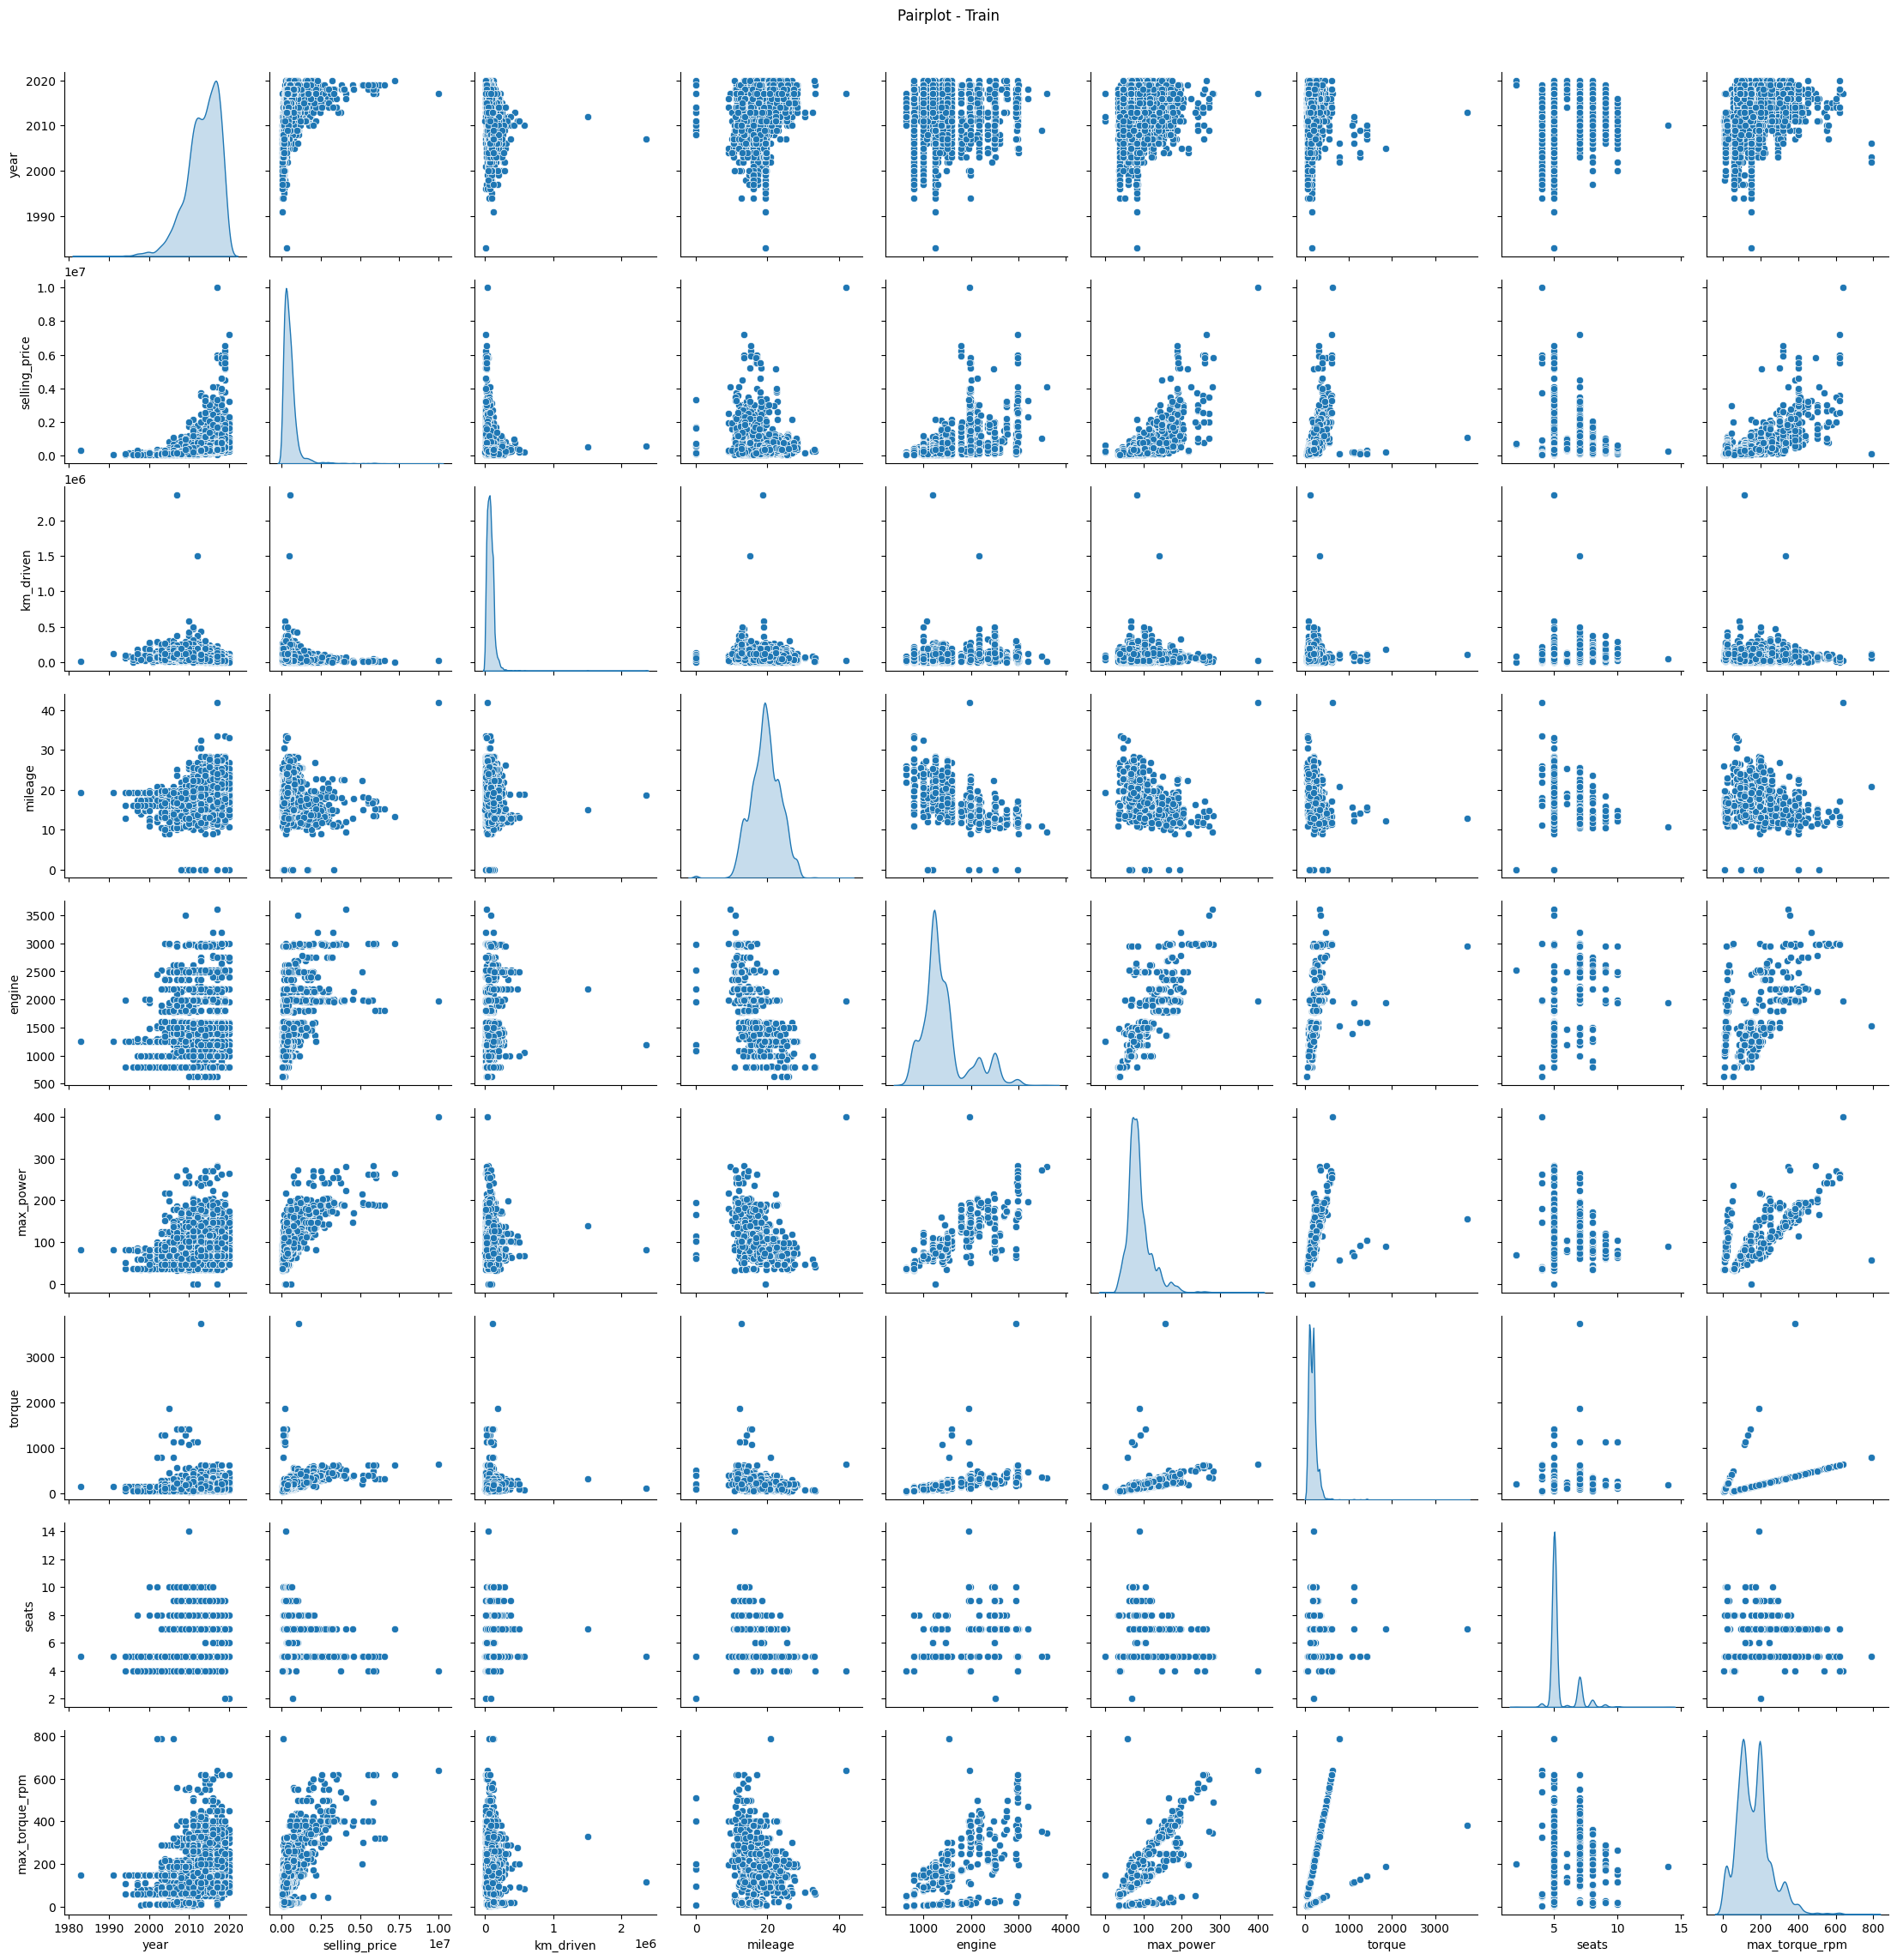

In [18]:
# Шаг 1: pairplot для train
numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Числовые столбцы: {numeric_cols}')

sns.pairplot(df_train[numeric_cols], diag_kind='kde')
plt.suptitle('Pairplot - Train', y=1.02)
plt.show()

- **Связь с целевой переменной:** Да, видна связь цены с year, engine, max_power, torque, max_torque_rpm. Новее авто, мощнее двигатель - выше цена.

- **Гипотезы о корреляциях признаков:** Да, видны корреляции между engine и max_power (положительная), engine и torque, max_torque_rpm (положительная). Также km_driven и year имеют отрицательную связь.


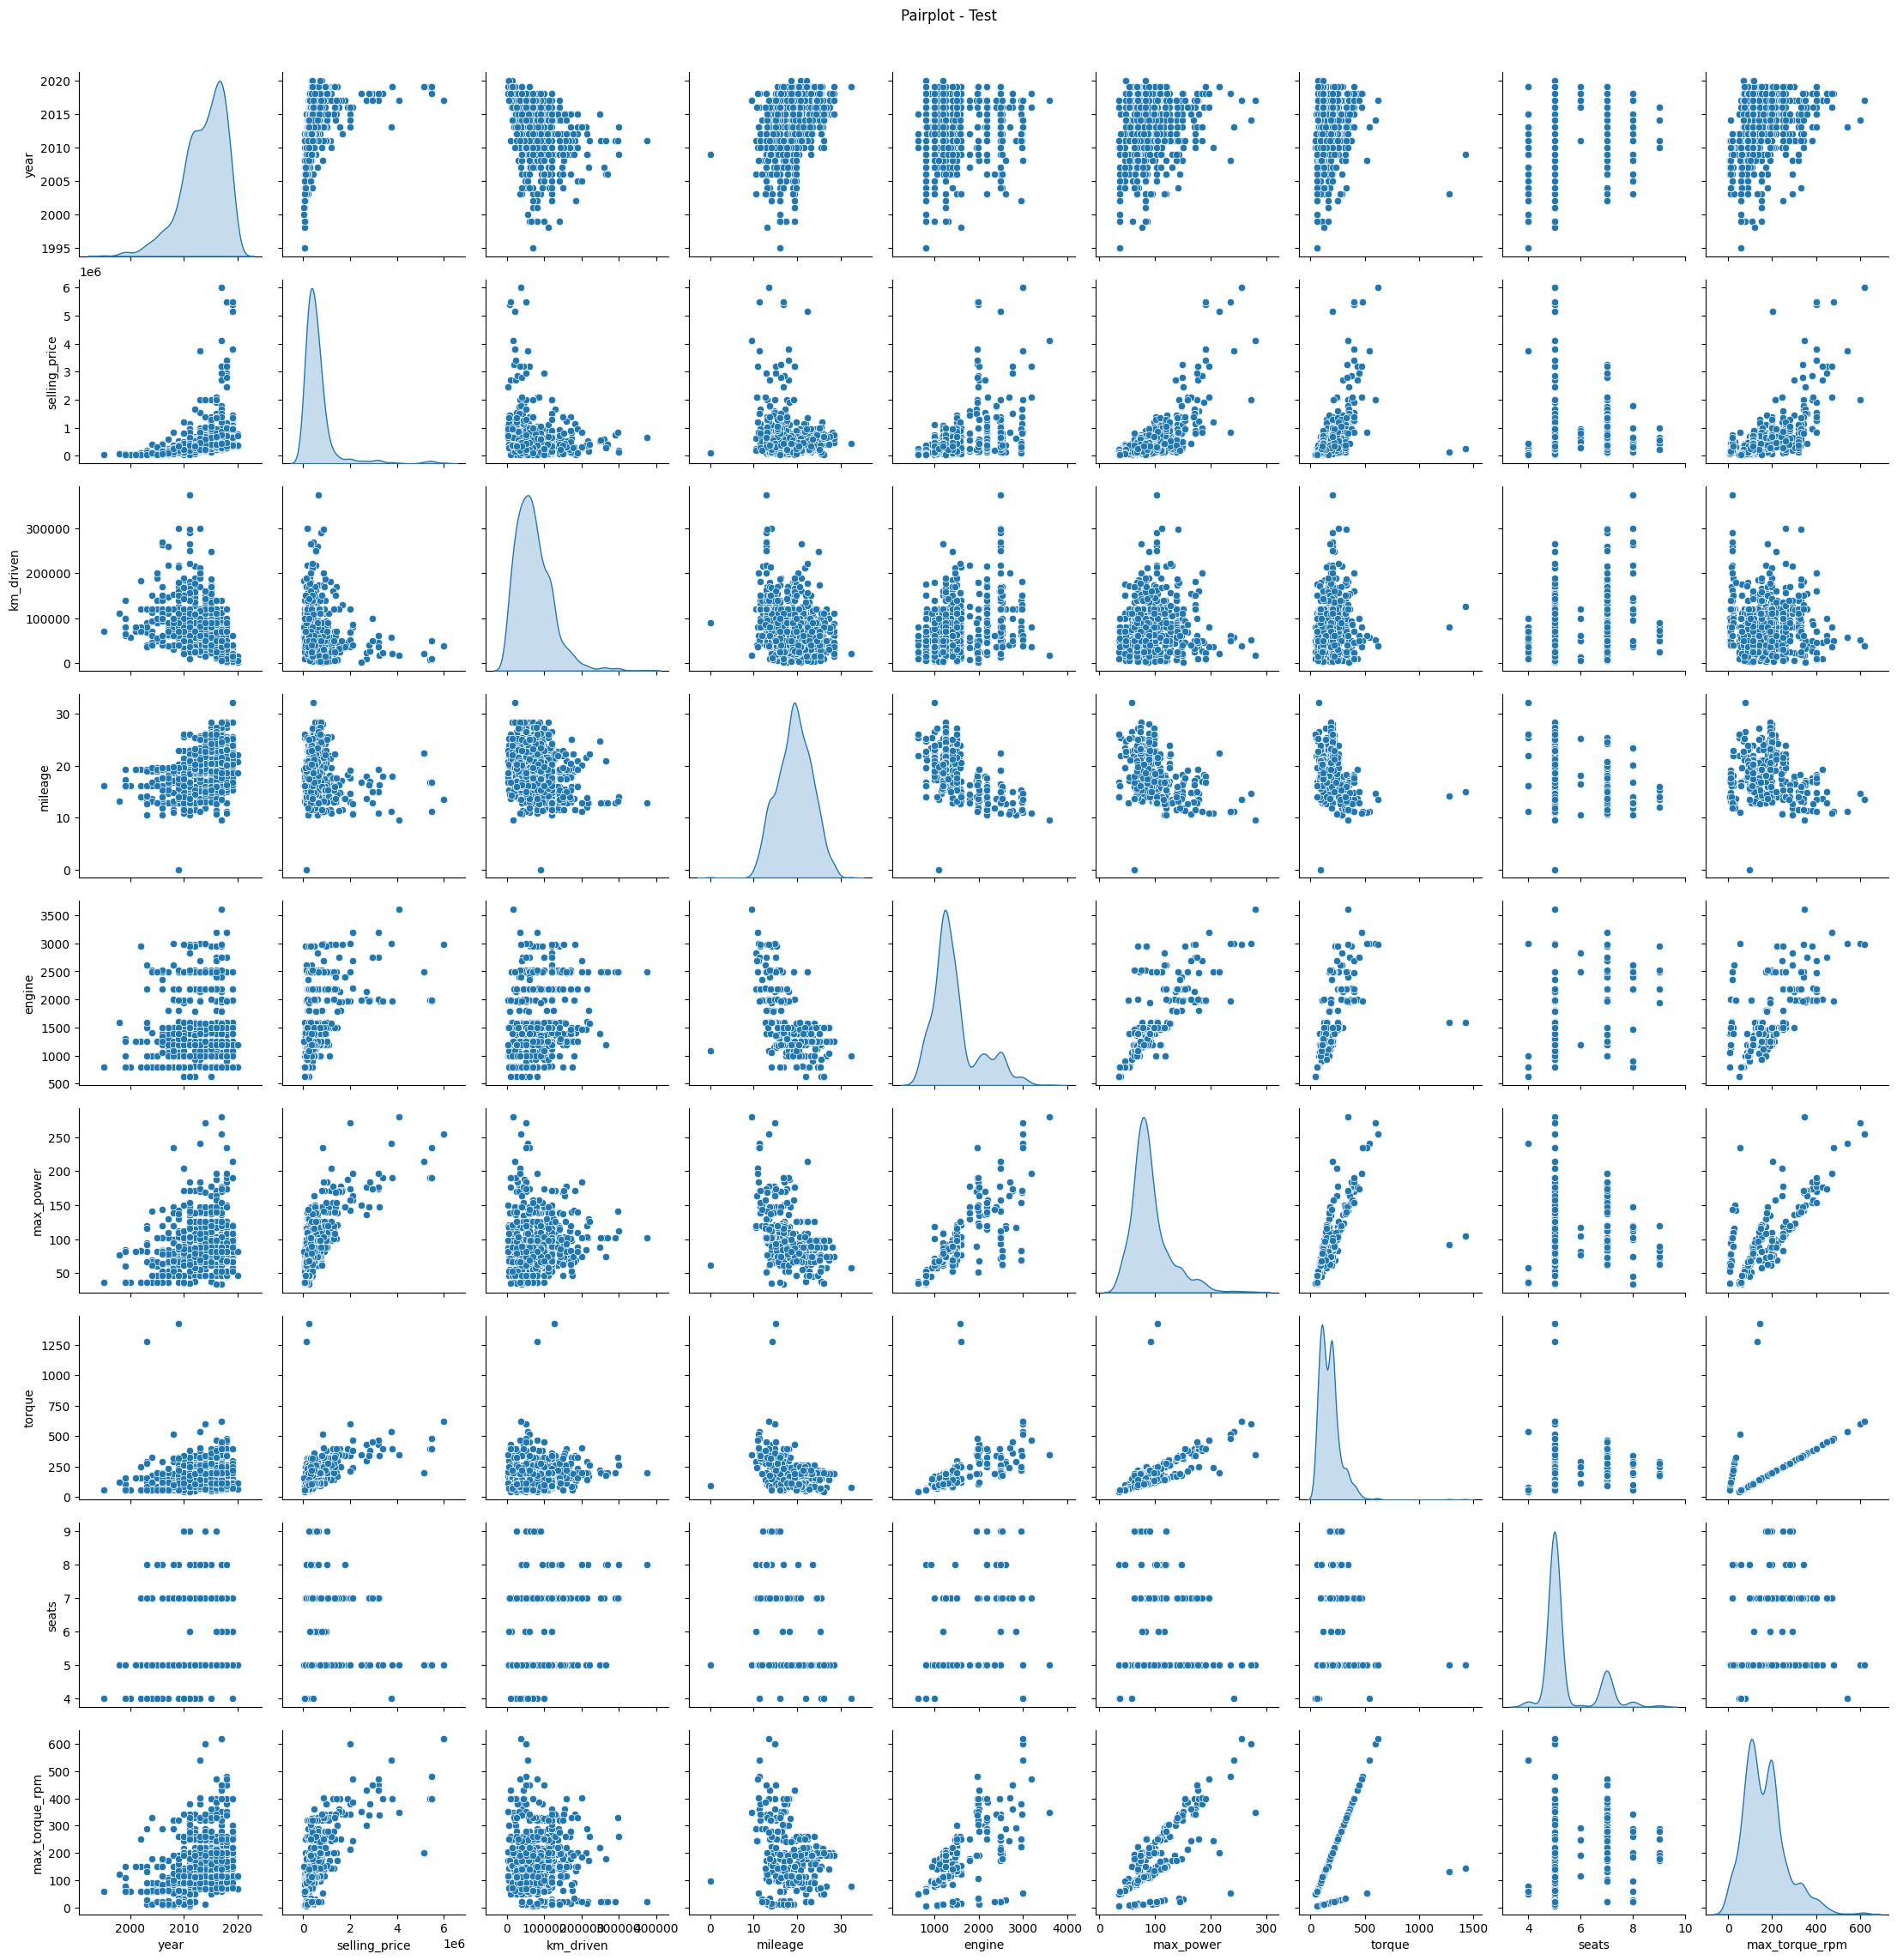

In [19]:
# Шаг 2: pairplot для test
sns.pairplot(df_test[numeric_cols], diag_kind='kde')
plt.suptitle('Pairplot - Test', y=1.02)
plt.show()


**Похожи ли train и test?**

Да, распределения на train и test похожи - форма распределений и характер зависимостей между признаками совпадают. Это говорит о корректном разбиении данных - модель, обученная на train, должна хорошо работать на test.


### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

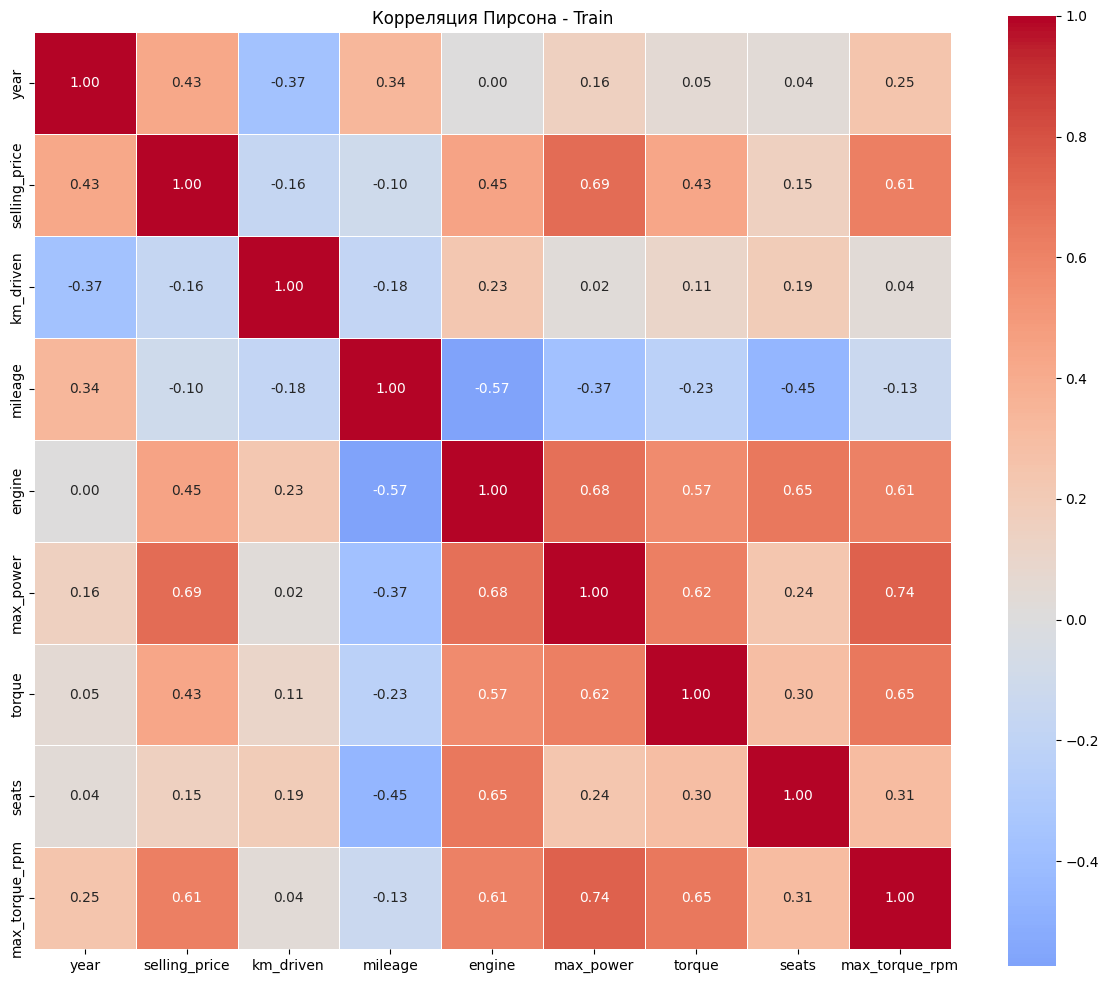

In [20]:
# Корреляция Пирсона
corr_matrix = df_train[numeric_cols].corr()

# Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Корреляция Пирсона - Train')
plt.tight_layout()
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

**Ответы:**

1. **Наименее скоррелированы:** seats и engine, km_driven и max_power

2. **Сильная положительная линейная! связь:** engine и max_torque_rpm, max_power и max_torque_rpm и т д все что про мощность

3. **Год и пробег:** Да, правильно. Корреляция между year и km_driven отрицательна, и хоть это не повод говорить о причинность, тем не менее по логике да, чем раньше выпуск машины, тем больше она скорее всего проехала к моменту продажи

4. **Тип корреляции по умолчанию:** коэффициент корреляции Пирсона измеряет линейную зависимость между переменными

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [21]:
def spearman_corr_manual(x, y):
    rank_x = np.argsort(np.argsort(x)) + 1
    rank_y = np.argsort(np.argsort(y)) + 1
    
    n = len(x)
    d = rank_x - rank_y
    rho = 1 - (6 * np.sum(d**2)) / (n * (n**2 - 1))
    return rho

# Тест на двух признаках
x = df_train['engine'].values
y = df_train['max_power'].values

manual_spearman = spearman_corr_manual(x, y)
print(f'Спирмен (вручную): {manual_spearman:.4f}')

library_spearman = df_train[['engine', 'max_power']].corr(method='spearman').iloc[0, 1]
print(f'Спирмен (pandas): {library_spearman:.4f}')

print(f'Разница: {abs(manual_spearman - library_spearman):.6f}')

Спирмен (вручную): 0.7111
Спирмен (pandas): 0.7131
Разница: 0.002055


interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


/home/dxdxxd/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


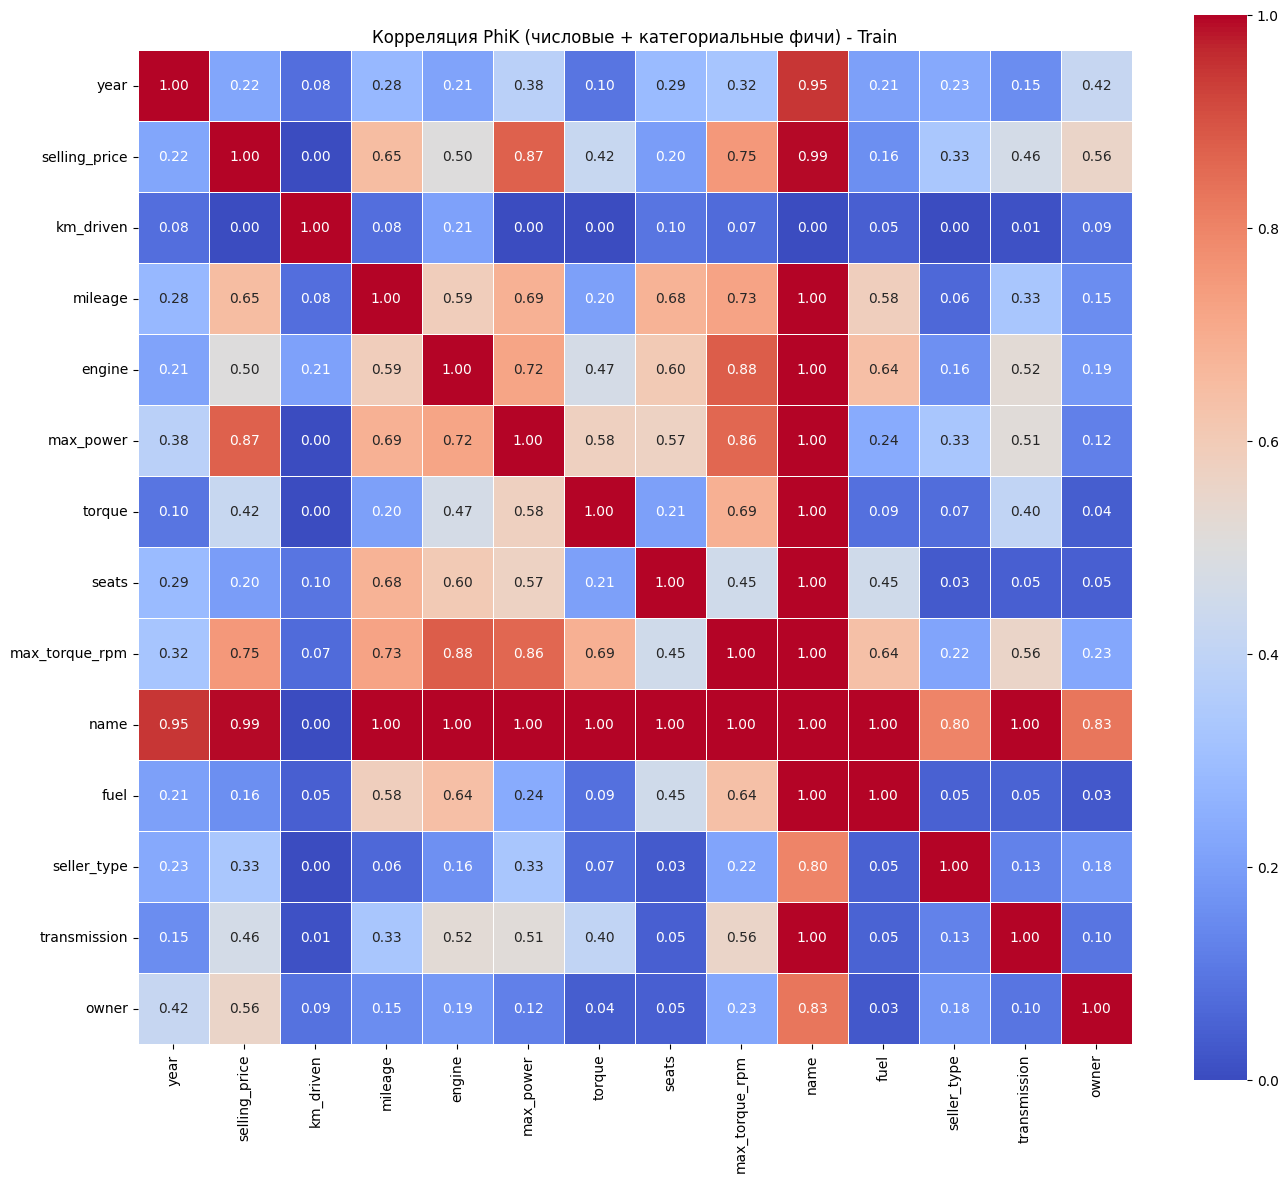

In [22]:
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']
all_cols_for_phik = numeric_cols + categorical_cols

phik_matrix = df_train[all_cols_for_phik].phik_matrix()

plt.figure(figsize=(14, 12))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5)
plt.title('Корреляция PhiK (числовые + категориальные фичи) - Train')
plt.tight_layout()
plt.show()

# Интерпретация:
# PhiK позволяет увидеть связи между категориальными и числовыми признаками,
# которые недоступны при использовании только Пирсона/Спирмена


**Выводы:**

**Спирмен - Пирсон:**
- Спирмен работает с рангами, устойчив к выбросам и видит не только линейные зависимости
- Ручная реализация дает результат близкий к библиотечному 

**PhiK корреляция:**
- PhiK работает с любыми типами данных (числовые и категориальные)
- Значения от 0 до 1 (0 - нет связи, 1 - сильная связь)

**Интерпретация результатов PhiK:**

*Сильные корреляции числовых признаков (>0.7):*
- `selling_price` - `max_power` (0.87) - мощность двигателя сильнее всего влияет на цену, крутые тачки делают врум врум громче 
- `max_power` - `max_torque_rpm` (0.86), `engine` - `max_power` (0.72), `engine` - `max_torque_rpm` (0.88) - характеристики двигателя тесно связаны, вот и все, что тут можно сказать

*Корреляции категориальных с числовыми признаками:*
- `owner` - `selling_price` (0.56) - частый "из рук в руки" - ниже цена
- `transmission` - `selling_price` (0.46) - тип трансмиссии влияет на стоимость, автомат дороже, покажу это ниже на доп. графиках
- `fuel` - `engine` (0.64) - тип топлива связан с объёмом двигателя, дизель чаще гоняет на больших объёмах врум врум
- `transmission` - `max_power` (0.51) - автомат чаще ставят на мощные машины

*Особенность `name`:*
- `name` имеет корреляцию ~1.0 почти со всеми признаками, т. к. много уникальный называний, видимо


### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

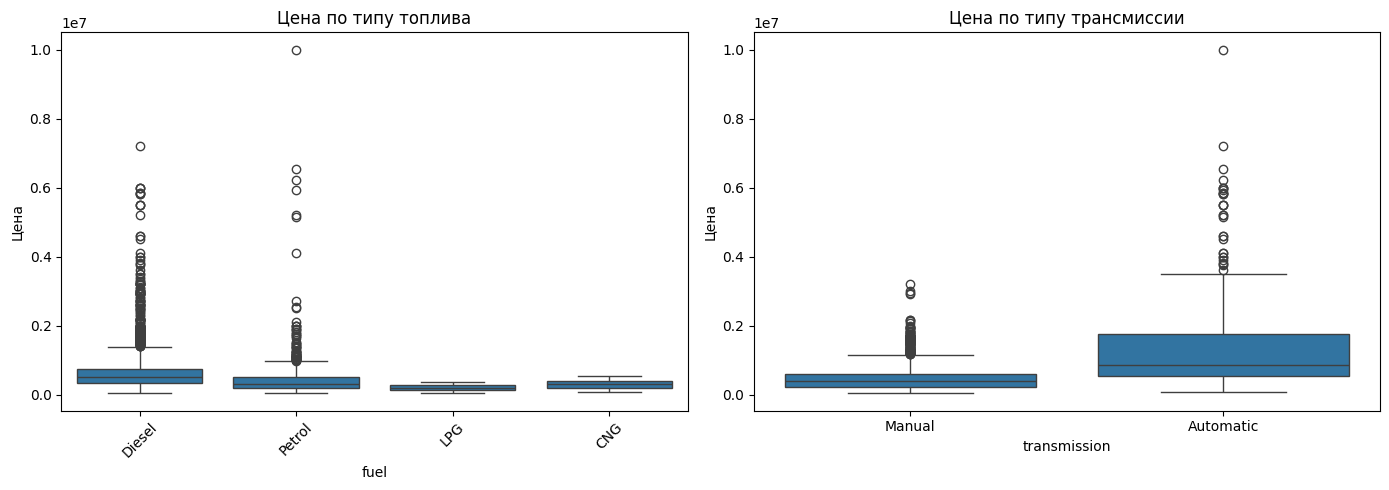

In [23]:
# График 1: Распределение цены по типу топлива
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot цены по типу топлива
sns.boxplot(data=df_train, x='fuel', y='selling_price', ax=axes[0])
axes[0].set_title('Цена по типу топлива')
axes[0].set_ylabel('Цена')
axes[0].tick_params(axis='x', rotation=45)

# Boxplot цены по типу трансмиссии
sns.boxplot(data=df_train, x='transmission', y='selling_price', ax=axes[1])
axes[1].set_title('Цена по типу трансмиссии')
axes[1].set_ylabel('Цена')

plt.tight_layout()
plt.show()

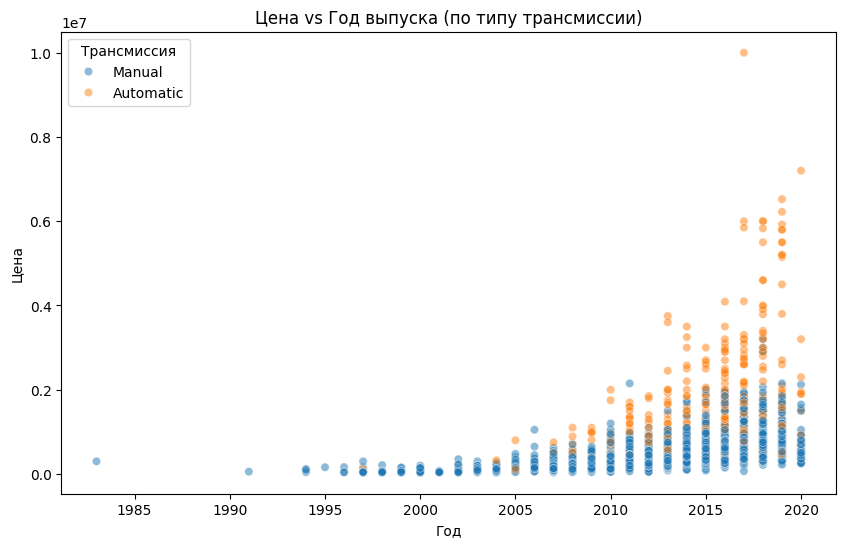

In [24]:
# График 2: Зависимость цены от года с разбивкой по трансмиссии
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='year', y='selling_price', hue='transmission', alpha=0.5)
plt.title('Цена vs Год выпуска (по типу трансмиссии)')
plt.xlabel('Год')
plt.ylabel('Цена')
plt.legend(title='Трансмиссия')
plt.show()


**Обоснование графиков:**

**График 1 Цена - тип топлива / цена - трансмиссия:**
- Показывает влияние категориальных признаков на цену, чего не было в pairplot
- Видно, что Diesel авто дороже Petrol, а Automatic дороже Manual

**График 2 Цена - год выпска с разбивкой по типу трансмисии:**
- Комбинирует числовой и категориальный признак
- Показывает, что Automatic авто появились на рынке и стали популярными позже, и в среднем дороже


# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [25]:
# Целевая переменная
y_train = df_train['selling_price']

# Только вещественные признаки (без категориальных, кроме seats который мжно считать и категориальным, но тут мы его возьмем все равно как  int )
numeric_features = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']
X_train = df_train[numeric_features].copy()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (5840, 8)
y_train shape: (5840,)


In [26]:
# Выбранные вещественные признаки:
# year - год выпуска
# km_driven - пробег
# mileage - расход топлива
# engine - объем двигателя
# max_power - максимальная мощность
# torque - крутящий момент
# seats - количество мест
# max_torque_rpm - обороты макс. крутящего момента

print('Признаки:', numeric_features)

Признаки: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


In [27]:
y_test = df_test['selling_price']
X_test = df_test[numeric_features].copy()

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_test shape: (1000, 8)
y_test shape: (1000,)


### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [28]:
# Обучаем линейную регрессию
lr = LinearRegression()
lr.fit(X_train, y_train)

# Предсказания
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Метрики
print('Linear Regression (без стандартизации):')
print(f'Train R2: {r2_score(y_train, y_train_pred):.4f}')
print(f'Test R2:  {r2_score(y_test, y_test_pred):.4f}')
print(f'Train MSE: {MSE(y_train, y_train_pred):.0f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred):.0f}')

Linear Regression (без стандартизации):
Train R2: 0.5985
Test R2:  0.5990
Train MSE: 115077360591
Test MSE:  230480462349


**Выводы по метрикам:**
- R2 ~0.6 - модель объясняет 60% дисперсии цены - сойдет для бейзлайна
- R2 на train и test близки - нет сильного переобучения
- MSE большой из-за масштаба цен (сотни тысяч)


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [29]:
def r2_manual(y_true, y_pred):
    '''
    R2 = 1 - SS_res / SS_tot
    SS_res = sum((y_true - y_pred)^2) - остаточная сумма квадратов
    SS_tot = sum((y_true - y_mean)^2) - общая сумма квадратов
    '''
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

# Проверка
r2_sklearn = r2_score(y_test, y_test_pred)
r2_hand = r2_manual(y_test.values, y_test_pred)

print(f'R2 sklearn: {r2_sklearn:.6f}')
print(f'R2 вручную: {r2_hand:.6f}')


R2 sklearn: 0.599045
R2 вручную: 0.599045


**Формула R2:**

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

- **SS_res (остаточная сумма квадратов)** = $\sum(y_i - \hat{y}_i)^2$ - сумма квадратов ошибок предсказания

- **SS_tot (общая сумма квадратов)** = $\sum(y_i - \bar{y})^2$ - дисперсия

- **R2** показывает долю объясненной дисперсии. R2=1 - идеальная модель, R2=0 - модель не лучше среднего.


### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [30]:
def adjusted_r2(y_true, y_pred, n_features):
    '''
    Adjusted R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)
    n - количество наблюдений (строк)
    p - количество признаков (столбцов)
    '''
    n = len(y_true)
    p = n_features
    r2 = r2_manual(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Вычисляем
n_features = X_test.shape[1]
adj_r2 = adjusted_r2(y_test.values, y_test_pred, n_features)
r2 = r2_manual(y_test.values, y_test_pred)

print(f'R2:          {r2:.6f}')
print(f'Adjusted R2: {adj_r2:.6f}')
print(f'Разница:     {r2 - adj_r2:.6f}')

R2:          0.599045
Adjusted R2: 0.595808
Разница:     0.003237


не запомнил с лекций про adjusted r2 (если вообще было), так что спрашивал у нейронки, когда она применяется и почему хороша и тд

**Когда применяется Adjusted R2?**

- Adjusted R2 штрафует за добавление новых признаков
- Обычный R2 всегда растет при добавлении признаков (даже бесполезных)
- Adjusted R2 применяется для сравнения моделей с разным числом признаков
- Помогает бороться с переобучением при отборе признаков

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [31]:
# Стандартизация - обучаем только на train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучаем модель на стандартизированных данных
lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_train_pred_scaled = lr_scaled.predict(X_train_scaled)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)

print('Linear Regression (со стандартизацией):')
print(f'Train R2: {r2_score(y_train, y_train_pred_scaled):.4f}')
print(f'Test R2:  {r2_score(y_test, y_test_pred_scaled):.4f}')
print(f'Train MSE: {MSE(y_train, y_train_pred_scaled):.0f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred_scaled):.0f}')

Linear Regression (со стандартизацией):
Train R2: 0.5985
Test R2:  0.5990
Train MSE: 115077360591
Test MSE:  230480462349


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [32]:
# Важность признаков по коэффициентам
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': lr_scaled.coef_,
    'abs_coefficient': np.abs(lr_scaled.coef_)
}).sort_values('abs_coefficient', ascending=False)

print('Важность признаков (по модулю коэффициента):')
display(feature_importance)

print(f'Наиболее информативный признак: {feature_importance.iloc[0]["feature"]}')

Важность признаков (по модулю коэффициента):


feature    coefficient  abs_coefficient
4       max_power  278403.443328    278403.443328
0            year  149096.983670    149096.983670
7  max_torque_rpm   71839.750025     71839.750025
1       km_driven  -44922.966289     44922.966289
3          engine   40849.627845     40849.627845
6           seats  -30274.065702     30274.065702
2         mileage    7756.280315      7756.280315
5          torque   -1248.455597      1248.455597

Наиболее информативный признак: max_power


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [33]:
# Lasso с параметрами по умолчанию
lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

print('Lasso (alpha=1.0 по умолчанию):')
print(f'Train R2: {r2_score(y_train, y_train_pred_lasso):.4f}')
print(f'Test R2:  {r2_score(y_test, y_test_pred_lasso):.4f}')
print(f'Train MSE: {MSE(y_train, y_train_pred_lasso):.0f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred_lasso):.0f}')
# Проверяем обнуление весов
lasso_coefs = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': lasso.coef_
})
print('Коэффициенты Lasso:')
display(lasso_coefs)

zeroed = lasso_coefs[lasso_coefs['coefficient'] == 0]
print(f'Обнуленных весов: {len(zeroed)}')
if len(zeroed) > 0:
    print(f'Обнуленные признаки: {zeroed["feature"].tolist()}')

Lasso (alpha=1.0 по умолчанию):
Train R2: 0.5985
Test R2:  0.5990
Train MSE: 115077360607
Test MSE:  230481177214
Коэффициенты Lasso:


feature    coefficient
0            year  149097.141948
1       km_driven  -44921.879094
2         mileage    7754.024925
3          engine   40844.041013
4       max_power  278403.232469
5          torque   -1245.041903
6           seats  -30271.350324
7  max_torque_rpm   71838.878617

Обнуленных весов: 0


**Почему веса не обнулились?**

При alpha=1.0 (по умолчанию) регуляризация слишком слабая для наших данных. Все признаки достаточно информативны, и Lasso не зануляет их. Чтобы обнулить веса, нужно увеличить alpha.


### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [34]:
# GridSearchCV для Lasso
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

lasso_cv = GridSearchCV(Lasso(), param_grid_lasso, cv=10, scoring='r2')
lasso_cv.fit(X_train_scaled, y_train)

print('GridSearchCV Lasso:')
print(f'Лучшие параметры: {lasso_cv.best_params_}')
print(f'Лучший R2 (CV): {lasso_cv.best_score_:.4f}')

# Тест лучшей модели
y_test_pred_lasso_cv = lasso_cv.predict(X_test_scaled)
print(f'Test R2: {r2_score(y_test, y_test_pred_lasso_cv):.4f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred_lasso_cv):.0f}')
# Сколько моделей обучено
n_models = len(param_grid_lasso['alpha']) * 10  # 7 * 10
print(f'Всего обучено моделей: {n_models}')

# Коэффициенты лучшей модели
print('Коэффициенты лучшей Lasso:')
best_lasso_coefs = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': lasso_cv.best_estimator_.coef_
})
display(best_lasso_coefs)

GridSearchCV Lasso:
Лучшие параметры: {'alpha': 1000}
Лучший R2 (CV): 0.5756
Test R2: 0.5978
Test MSE:  231187003081
Всего обучено моделей: 70
Коэффициенты лучшей Lasso:


feature    coefficient
0            year  149038.009313
1       km_driven  -43816.418876
2         mileage    5639.920772
3          engine   35713.642326
4       max_power  278657.402552
5          torque       0.000000
6           seats  -27521.105180
7  max_torque_rpm   71818.117586

1. **Сколько моделей:** 7 значений alpha * 10 фолдов = 70 моделей

2. **Параметр alpha:** коэффициент регуляризации L1. Чем больше alpha, тем сильнее штраф за большие веса, тем больше весов обнуляется.


**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [35]:
# GridSearchCV для ElasticNet
param_grid_elastic = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_cv = GridSearchCV(ElasticNet(), param_grid_elastic, cv=10, scoring='r2')
elastic_cv.fit(X_train_scaled, y_train)

print('GridSearchCV ElasticNet:')
print(f'Лучшие параметры: {elastic_cv.best_params_}')
print(f'Лучший R2 (CV): {elastic_cv.best_score_:.4f}')

y_test_pred_elastic = elastic_cv.predict(X_test_scaled)
print(f'Test R2: {r2_score(y_test, y_test_pred_elastic):.4f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred_elastic):.0f}')
# Сколько моделей обучено
n_models_elastic = len(param_grid_elastic['alpha']) * len(param_grid_elastic['l1_ratio']) * 10
print(f'Всего обучено моделей: {n_models_elastic}')

GridSearchCV ElasticNet:
Лучшие параметры: {'alpha': 1, 'l1_ratio': 0.9}
Лучший R2 (CV): 0.5803
Test R2: 0.5807
Test MSE:  240996965888
Всего обучено моделей: 250


1. **Сколько моделей:** 5 * 5 * 10 = 250

2. **Лучшие параметры:** alpha = 1, l1_ratio = 0.9


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [36]:
# L0 регуляризация: Loss = MSE + lambda * ||w||_0
# ||w||_0 - количество ненулевых коэффициентов
# lambda - коэффициент регуляризации

def l0_regularized_regression(X_train, y_train, lambda_l0):
    '''
    L0 регуляризация: минимизируем MSE + lambda * ||w||_0
    '''
    n_features = X_train.shape[1]
    best_loss = np.inf
    best_features = None
    
    # Перебираем все подмножества признаков
    for k in range(1, n_features + 1):
        for features in combinations(range(n_features), k):
            features = list(features)
            lr = LinearRegression()
            
            # MSE оцениваем через CV только на train
            mse_scores = -cross_val_score(lr, X_train[:, features], y_train, 
                                          cv=5, scoring='neg_mean_squared_error')
            mse = np.mean(mse_scores)
            
            # L0 loss = MSE + lambda * (число ненулевых весов)
            loss = mse + lambda_l0 * k
            
            if loss < best_loss:
                best_loss = loss
                best_features = features
    
    # Обучаем финальную модель на отобранных признаках
    final_model = LinearRegression()
    final_model.fit(X_train[:, best_features], y_train)
    
    return final_model, best_features

# Эксперименты с разными lambda
print('L0 регуляризация: Loss = MSE + lambda * ||w||_0')

for lambda_l0 in [1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9]:
    model, features = l0_regularized_regression(X_train_scaled, y_train.values, lambda_l0)
    feature_names_selected = [numeric_features[i] for i in features]
    
    y_pred_test = model.predict(X_test_scaled[:, features])
    r2_test = r2_score(y_test, y_pred_test)
    print(f'Test MSE:  {MSE(y_test, y_pred_test):.0f}')
    print(f'lambda={lambda_l0:.0e}: {len(features)} признаков, Test R2={r2_test:.4f}')
    print(f'  -> {feature_names_selected}')

L0 регуляризация: Loss = MSE + lambda * ||w||_0
Test MSE:  230468582778
lambda=1e+02: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=1e+03: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=1e+04: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=1e+05: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=1e+06: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=1e+07: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', 'engine', 'max_power', 'seats', 'max_torque_rpm']
Test MSE:  230468582778
lambda=5e+07: 6 признаков, Test R2=0.5991
  -> ['year', 'km_driven', '

**Анализ L0 регуляризации:**

- **Формула:** Loss = MSE + λ * ||w||_0, где ||w||_0 - число ненулевых весов
- **λ (lambda)** - коэффициент регуляризации, штраф за каждый используемый признак
- При малом λ используются все признаки, при большом - только самые важные
- L0 дает интерпретируемые разреженные модели, но требует полного перебора (очень плохо, на 20 признаках уже все.....)

# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [37]:
# Извлекаем бренд из name (первое слово)
df_train['brand'] = df_train['name'].str.split().str[0]
df_test['brand'] = df_test['name'].str.split().str[0]

print(f'Уникальных брендов в train: {df_train["brand"].nunique()}')
print(f'Топ-10 брендов:')
print(df_train['brand'].value_counts().head(10))

# Создаем X_train_cat с категориальными признаками
cat_cols = ['brand', 'fuel', 'seller_type', 'transmission', 'owner']
X_train_cat = df_train[numeric_features + cat_cols].copy()
X_test_cat = df_test[numeric_features + cat_cols].copy()

print(f'\nX_train_cat shape: {X_train_cat.shape}')

Уникальных брендов в train: 30
Топ-10 брендов:
brand
Maruti        1804
Hyundai       1058
Mahindra       611
Tata           534
Toyota         309
Ford           308
Honda          308
Chevrolet      188
Renault        171
Volkswagen     153
Name: count, dtype: int64

X_train_cat shape: (5840, 13)


In [38]:
assert X_train_cat.shape == (5840, 11)

AssertionError: 

In [39]:
X_train_cat.describe(include='object')

brand    fuel seller_type transmission        owner
count     5840    5840        5840         5840         5840
unique      30       4           3            2            5
top     Maruti  Diesel  Individual       Manual  First Owner
freq      1804    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [ ]:
# Числовые признаки (без seats)
num_cols_for_ohe = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']
cat_cols_for_ohe = ['brand', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']

# OneHotEncoder с drop='first' для избежания мультиколлинеарности
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train_cat[cat_cols_for_ohe].astype(str))

# Трансформируем
X_train_ohe = ohe.transform(X_train_cat[cat_cols_for_ohe].astype(str))
X_test_ohe = ohe.transform(X_test_cat[cat_cols_for_ohe].astype(str))

# Объединяем числовые и OHE признаки
X_train_full = np.hstack([X_train_cat[num_cols_for_ohe].values, X_train_ohe])
X_test_full = np.hstack([X_test_cat[num_cols_for_ohe].values, X_test_ohe])

print(f'X_train_full shape: {X_train_full.shape}')
print(f'X_test_full shape: {X_test_full.shape}')
print(f'OHE признаков: {X_train_ohe.shape[1]}')

X_train_full shape: (5840, 54)
X_test_full shape: (1000, 54)
OHE признаков: 47


/home/dxdxxd/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?


1. **Как корректно работать с OHE?**
   - Обучать encoder только на train (fit на train, transform на train и test), чтобы не было даталика
   - Использовать `handle_unknown='ignore'` для новых категорий в test, если не было в трейне, то откуда их взять на тесте
   - Удалять один столбец (`drop='first'`), чтобы не было мультиколлинеарности, руками это на дз из математики показывали даже

2. **Почему удаляем один столбец?**
   - Избегаем мультиколлинеарности 
   - Если есть n категорий, то n-1 столбцов полностью описывают признак

3. **Можно ли удалить k незначимых столбцов из n-1?**
   - Нет, нельзя произвольно удалять OHE-столбцы, потому что они вместе кодируют 1 признак. Удалять 1 признак, потом заново кодировать OHE

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [41]:
# Стандартизация полного набора признаков
scaler_full = StandardScaler()
X_train_full_scaled = scaler_full.fit_transform(X_train_full)
X_test_full_scaled = scaler_full.transform(X_test_full)

# GridSearchCV для Ridge
param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 500, 550, 600, 750, 875, 950, 1000, 1050, 1100]
}

ridge_cv = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring='r2')
ridge_cv.fit(X_train_full_scaled, y_train)

print('GridSearchCV Ridge (с категориальными признаками):')
print(f'Лучшие параметры: {ridge_cv.best_params_}')
print(f'Лучший R2 (CV): {ridge_cv.best_score_:.4f}')

y_test_pred_ridge = ridge_cv.predict(X_test_full_scaled)
print(f'Test R2: {r2_score(y_test, y_test_pred_ridge):.4f}')
print(f'Test MSE:  {MSE(y_test, y_test_pred_ridge):.0f}')
# Сравнение с предыдущими моделями
print('Сравнение моделей')
print(f'LinearRegression (только числовые): Test R2 = {r2_score(y_test, y_test_pred):.4f}')
print(f'Ridge (с категориальными):         Test R2 = {r2_score(y_test, y_test_pred_ridge):.4f}')
print(f'LinearRegression (только числовые MSE: {MSE(y_test, y_test_pred):.0f}')
print(f'Ridge (с категориальными) MSE:  {MSE(y_test, y_test_pred_ridge):.0f}')


GridSearchCV Ridge (с категориальными признаками):
Лучшие параметры: {'alpha': 550}
Лучший R2 (CV): 0.7117
Test R2: 0.7860
Test MSE:  123024889014
Сравнение моделей
LinearRegression (только числовые): Test R2 = 0.5990
Ridge (с категориальными):         Test R2 = 0.7860
LinearRegression (только числовые MSE: 230480462349
Ridge (с категориальными) MSE:  123024889014


**Удалось ли улучшить качество?**

Да, добавление категориальных признаков (бренд, тип топлива, трансмиссия и т.д.) улучшило R2. Это логично - бренд авто сильно влияет на цену (Mercedes дороже хонды, закон Веблена, вот это все).


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [42]:
# Пункт 1

# Копируем данные, ничего не перезатираем, а то будет грустно...
X_train_fe = X_train_cat.copy()
X_test_fe = X_test_cat.copy()

# 1. Мощность на литр объема (power_per_liter)
X_train_fe['power_per_liter'] = X_train_fe['max_power'] / (X_train_fe['engine'] / 1000)
X_test_fe['power_per_liter'] = X_test_fe['max_power'] / (X_test_fe['engine'] / 1000)

# 2. Квадрат года (зависимость цены от года квадратичная)
X_train_fe['year_squared'] = X_train_fe['year'] ** 2
X_test_fe['year_squared'] = X_test_fe['year'] ** 2

# 3. Возраст авто (2024 - год)
X_train_fe['age'] = 2024 - X_train_fe['year']
X_test_fe['age'] = 2024 - X_test_fe['year']

# 4. Пробег на год владения
X_train_fe['km_per_year'] = X_train_fe['km_driven'] / X_train_fe['age'].replace(0, 1)
X_test_fe['km_per_year'] = X_test_fe['km_driven'] / X_test_fe['age'].replace(0, 1)

# 5. Torque / Engine ratio
X_train_fe['torque_per_liter'] = X_train_fe['torque'] / (X_train_fe['engine'] / 1000)
X_test_fe['torque_per_liter'] = X_test_fe['torque'] / (X_test_fe['engine'] / 1000)

# 6. Логарифм пробега (сильно уехало распределение)
X_train_fe['log_km'] = np.log1p(X_train_fe['km_driven'])
X_test_fe['log_km'] = np.log1p(X_test_fe['km_driven'])

print('Новые признаки:')
new_features = ['power_per_liter', 'year_squared', 'age', 'km_per_year', 'torque_per_liter', 'log_km']
print(new_features)
print(f'\nX_train_fe shape: {X_train_fe.shape}')

Новые признаки:
['power_per_liter', 'year_squared', 'age', 'km_per_year', 'torque_per_liter', 'log_km']

X_train_fe shape: (5840, 19)


In [43]:
# Подготовка данных с новыми признаками
num_cols_fe = numeric_features + new_features
cat_cols_fe = ['brand', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']

# OHE для категориальных
ohe_fe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe_fe.fit(X_train_fe[cat_cols_fe].astype(str))

X_train_ohe_fe = ohe_fe.transform(X_train_fe[cat_cols_fe].astype(str))
X_test_ohe_fe = ohe_fe.transform(X_test_fe[cat_cols_fe].astype(str))

# Объединяем
X_train_fe_full = np.hstack([X_train_fe[num_cols_fe].values, X_train_ohe_fe])
X_test_fe_full = np.hstack([X_test_fe[num_cols_fe].values, X_test_ohe_fe])

# Стандартизация
scaler_fe = StandardScaler()
X_train_fe_scaled = scaler_fe.fit_transform(X_train_fe_full)
X_test_fe_scaled = scaler_fe.transform(X_test_fe_full)

print(f'X_train с новыми признаками: {X_train_fe_scaled.shape}')


X_train с новыми признаками: (5840, 61)


/home/dxdxxd/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
# Обучаем Ridge с новыми признаками
ridge_fe = GridSearchCV(Ridge(), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 500, 550, 600, 750, 875, 950, 1000, 1050, 1100]}, cv=10, scoring='r2')
ridge_fe.fit(X_train_fe_scaled, y_train)

y_pred_fe = ridge_fe.predict(X_test_fe_scaled)

print('Результаты')
print(f'Ridge (без новых признаков): Test R2 = {r2_score(y_test, y_test_pred_ridge):.4f}')
print(f'Ridge (с новыми признаками): Test R2 = {r2_score(y_test, y_pred_fe):.4f}')
print(f'Лучший alpha: {ridge_fe.best_params_}')
print(f'Улучшение: {(r2_score(y_test, y_pred_fe) - r2_score(y_test, y_test_pred_ridge))*100:.2f}%')
print(f'Ridge (без новых признаков) MSE: {MSE(y_test, y_test_pred_ridge):.0f}')
print(f'Ridge (с новыми признаками) MSE: {MSE(y_test, y_pred_fe):.0f}') 

Результаты
Ridge (без новых признаков): Test R2 = 0.7860
Ridge (с новыми признаками): Test R2 = 0.7955
Лучший alpha: {'alpha': 0.001}
Улучшение: 0.95%
Ridge (без новых признаков) MSE: 123024889014
Ridge (с новыми признаками) MSE: 117561346105


**Созданные признаки (пункт 1):**

1. **power_per_liter** - мощность на литр объема двигателя

llm: Литровая мощность ($N_{lit}$) — это показатель эффективности двигателя, отражающий, сколько лошадиных сил инженеры смогли «снять» с одного литра рабочего объема.В инженерной среде этот параметр считается главным индикатором форсированности двигателя (степени его напряженности). Чем выше эта цифра, тем более сложные технологии применены и тем выше нагрузка на детали.

2. **year_squared** - квадрат года
3. **age** - возраст авто в годах
4. **km_per_year** - средний пробег в год (интенсивность эксплуатации - крутой признак, думаю !!)
5. **torque_per_liter** - крутящий момент на литр объема

llm: Удельный крутящий момент (или момент на литр) — это показатель, который говорит о «силе» каждого взрыва в цилиндрах, независимо от того, как быстро вращается двигатель.
Если литровая мощность показывает, как быстро двигатель может совершать работу, то литровый момент показывает, насколько эффективно он наполняется воздухом и сжигает топливо за один такт.

6. **log_km** - логарифм пробега (нормализует скошенное распределение)

In [45]:
#Пункт 2

# Копируем данные
X_train_fe2 = X_train_fe.copy()
X_test_fe2 = X_test_fe.copy()

# 1. Извлекаем модель из name
X_train_fe2['model'] = df_train['name'].str.split().str[1].fillna('Unknown')
X_test_fe2['model'] = df_test['name'].str.split().str[1].fillna('Unknown')

# 2. Пороговые признаки по владельцам
# is_third_plus_owner - третий владелец или больше (хуже для цены, не бита не крашена, все дела)
owner_map = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 
             'Fourth & Above Owner': 4, 'Test Drive Car': 0}
X_train_fe2['owner_num'] = df_train['owner'].map(owner_map)
X_test_fe2['owner_num'] = df_test['owner'].map(owner_map)
X_train_fe2['is_third_plus_owner'] = (X_train_fe2['owner_num'] >= 3).astype(int)
X_test_fe2['is_third_plus_owner'] = (X_test_fe2['owner_num'] >= 3).astype(int)

# 3. Комбинированные правила
# is_premium_seller: первый/второй владелец + официальный дилер
X_train_fe2['is_premium_seller'] = ((X_train_fe2['owner_num'] <= 2) & 
                                     (df_train['seller_type'] == 'Dealer')).astype(int)
X_test_fe2['is_premium_seller'] = ((X_test_fe2['owner_num'] <= 2) & 
                                    (df_test['seller_type'] == 'Dealer')).astype(int)

# 4. is_low_mileage: пробег меньше медианы для возраста
median_km_per_year = X_train_fe2['km_per_year'].median()
X_train_fe2['is_low_mileage'] = (X_train_fe2['km_per_year'] < median_km_per_year).astype(int)
X_test_fe2['is_low_mileage'] = (X_test_fe2['km_per_year'] < median_km_per_year).astype(int)

# 5. is_automatic_diesel: автомат + дизель (премиум комбинация в Индии вроде как)
X_train_fe2['is_auto_diesel'] = ((df_train['transmission'] == 'Automatic') & 
                                  (df_train['fuel'] == 'Diesel')).astype(int)
X_test_fe2['is_auto_diesel'] = ((df_test['transmission'] == 'Automatic') & 
                                 (df_test['fuel'] == 'Diesel')).astype(int)

print('Новые признаки (пункт 2):')
new_features_2 = ['is_third_plus_owner', 'is_premium_seller', 'is_low_mileage', 'is_auto_diesel']
print(new_features_2)

print(f'\nРаспределение is_premium_seller: {X_train_fe2["is_premium_seller"].value_counts().to_dict()}')
print(f'Распределение is_auto_diesel: {X_train_fe2["is_auto_diesel"].value_counts().to_dict()}')


Новые признаки (пункт 2):
['is_third_plus_owner', 'is_premium_seller', 'is_low_mileage', 'is_auto_diesel']

Распределение is_premium_seller: {0: 5251, 1: 589}
Распределение is_auto_diesel: {0: 5578, 1: 262}


In [46]:
# Подготовка данных с признаками из пункта 2
num_cols_fe2 = num_cols_fe + new_features_2
cat_cols_fe2 = ['brand', 'fuel', 'seller_type', 'transmission', 'owner', 'seats', 'model']

# OHE
ohe_fe2 = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe_fe2.fit(X_train_fe2[cat_cols_fe2].astype(str))

X_train_ohe_fe2 = ohe_fe2.transform(X_train_fe2[cat_cols_fe2].astype(str))
X_test_ohe_fe2 = ohe_fe2.transform(X_test_fe2[cat_cols_fe2].astype(str))

# Объединяем
X_train_fe2_full = np.hstack([X_train_fe2[num_cols_fe2].values, X_train_ohe_fe2])
X_test_fe2_full = np.hstack([X_test_fe2[num_cols_fe2].values, X_test_ohe_fe2])

# Стандартизация
scaler_fe2 = StandardScaler()
X_train_fe2_scaled = scaler_fe2.fit_transform(X_train_fe2_full)
X_test_fe2_scaled = scaler_fe2.transform(X_test_fe2_full)

# Обучаем
ridge_fe2 = GridSearchCV(Ridge(), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 500, 550, 600, 750, 875, 950, 1000, 1050, 1100]}, cv=10, scoring='r2')
ridge_fe2.fit(X_train_fe2_scaled, y_train)

y_pred_fe2 = ridge_fe2.predict(X_test_fe2_scaled)

print('Результаты пункта 2')
print(f'Ridge (пункт 1):          Test R2 = {r2_score(y_test, y_pred_fe):.4f}')
print(f'Ridge (пункт 1 + 2):      Test R2 = {r2_score(y_test, y_pred_fe2):.4f}')
print(f'Размер признаков: {X_train_fe2_scaled.shape[1]}')
print(f'Ridge (пункт 1) MSE: {MSE(y_test, y_pred_fe):.0f}')
print(f'Ridge (пункт 1 + 2) MSE: {MSE(y_test, y_pred_fe2):.0f}')

/home/dxdxxd/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Результаты пункта 2
Ridge (пункт 1):          Test R2 = 0.7955
Ridge (пункт 1 + 2):      Test R2 = 0.9175
Размер признаков: 266
Ridge (пункт 1) MSE: 117561346105
Ridge (пункт 1 + 2) MSE: 47443360979


**признаки (пункт 2):**

1. **model** - модель авто (второе слово из name) - добавляет детализации

2. **is_third_plus_owner** - третий владелец или более (не бита не крашена)

3. **is_premium_seller** - комбинированное правило: первый/второй владелец + официальный дилер (базовый признак хорошего авто с рук)

4. **is_low_mileage** - пробег в год ниже медианы (меньше пробег - хорошо, если стояла не на морозе, конечно)

5. **is_auto_diesel** - автомат + дизель (премиум комбинация в Индии, сейчас сходит на нет из-за газовых двигателей, но кажется что все еще сохранет налет "премиумности")

In [47]:
# Обучение с логарифмом целевой переменной
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Используем данные из пункта 2
ridge_log = GridSearchCV(Ridge(), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 500, 550, 600, 750, 875, 950, 1000, 1050, 1100]}, cv=10, scoring='r2')
ridge_log.fit(X_train_fe2_scaled, y_train_log)

# Предсказания (обратное преобразование)
y_pred_log = np.expm1(ridge_log.predict(X_test_fe2_scaled))

print('Результаты с log(target)')
print(f'Ridge (обычный target):   Test R2 = {r2_score(y_test, y_pred_fe2):.4f}')
print(f'Ridge (log target):       Test R2 = {r2_score(y_test, y_pred_log):.4f}')
print(f'Ridge (обычный target) MSE: {MSE(y_test, y_pred_fe2):.0f}')
print(f'Ridge (log target) MSE: {MSE(y_test, y_pred_log):.0f}')


Результаты с log(target)
Ridge (обычный target):   Test R2 = 0.9175
Ridge (log target):       Test R2 = 0.9406
Ridge (обычный target) MSE: 47443360979
Ridge (log target) MSE: 34131241926


In [48]:
# Полиномиальные признаки (идея с курса Stepik)
# Берем только числовые признаки для полиномов
X_train_num = X_train_fe2[num_cols_fe2].values
X_test_num = X_test_fe2[num_cols_fe2].values

# Полиномиальные признаки степени 2
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_num)
X_test_poly = poly.transform(X_test_num)

print(f'Исходных числовых признаков: {X_train_num.shape[1]}')
print(f'После полиномов: {X_train_poly.shape[1]}')

# Объединяем полиномы + OHE
X_train_poly_full = np.hstack([X_train_poly, X_train_ohe_fe2])
X_test_poly_full = np.hstack([X_test_poly, X_test_ohe_fe2])

# Стандартизация
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly_full)
X_test_poly_scaled = scaler_poly.transform(X_test_poly_full)

print(f'Итого признаков: {X_train_poly_scaled.shape[1]}')

Исходных числовых признаков: 18
После полиномов: 171
Итого признаков: 419


In [49]:
# Обучаем Ridge с полиномами + log(target)
ridge_poly = GridSearchCV(Ridge(), {'alpha': [0.1, 1, 10, 100, 500, 1000, 5000]}, cv=10, scoring='r2')
ridge_poly.fit(X_train_poly_scaled, y_train_log)

# Предсказания
y_pred_poly = np.expm1(ridge_poly.predict(X_test_poly_scaled))

print('Результаты с полиномиальными признаками')
print(f'Ridge (без полиномов, log):  Test R2 = {r2_score(y_test, y_pred_log):.4f}')
print(f'Ridge (с полиномами, log):   Test R2 = {r2_score(y_test, y_pred_poly):.4f}')
print(f'\nЛучший alpha: {ridge_poly.best_params_}')
print(f'Ridge (без полиномов, log) MSE: {MSE(y_test, y_pred_log):.0f}')
print(f'Ridge (с полиномами, log) MSE: {MSE(y_test, y_pred_poly):.0f}')

Результаты с полиномиальными признаками
Ridge (без полиномов, log):  Test R2 = 0.9406
Ridge (с полиномами, log):   Test R2 = 0.9505

Лучший alpha: {'alpha': 100}
Ridge (без полиномов, log) MSE: 34131241926
Ridge (с полиномами, log) MSE: 28441375181


**Работа с данными (пункт 3):**

1. **Анализ целевой переменной:**
   - Распределение цены сильно скошено вправо (много дешевых, мало дорогих)
   - log-преобразование делает распределение ближе к нормальному

**Полиномиальные признаки (идея с курса Stepik):**

Линейная регрессия моделирует только линейные зависимости. Но зависимость цены от признаков может быть нелинейной

всееее лучше у меня ничего не получилось, за сим все с выбиванием скора !

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [50]:
def business_metric(y_true, y_pred):
    '''
    Доля прогнозов, отличающихся от реальных цен не более чем на 10%
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Относительная ошибка
    relative_error = np.abs(y_true - y_pred) / y_true
    
    # Доля прогнозов в пределах 10%
    within_10_percent = np.mean(relative_error <= 0.10)
    
    return within_10_percent

# Собираем всеeee предсказания для сравнения (хорошо, что не перезатерли...)
predictions = {
    'LinearRegression (числовые)': y_test_pred,
    'Ridge (OHE)': y_test_pred_ridge,
    'Ridge (пункт 1)': y_pred_fe,
    'Ridge (пункт 1+2)': y_pred_fe2,
    'Ridge (log target)': y_pred_log,
    'Ridge (полиномы)': y_pred_poly,
}


print('Бизнес метрика: доля прогнозов в пределах 10% от реальной цены')

for name, pred in predictions.items():
    metric = business_metric(y_test, pred)
    print(f'{name}: {metric:.2%}')

Бизнес метрика: доля прогнозов в пределах 10% от реальной цены
LinearRegression (числовые): 23.00%
Ridge (OHE): 32.30%
Ridge (пункт 1): 29.00%
Ridge (пункт 1+2): 38.30%
Ridge (log target): 46.50%
Ridge (полиномы): 47.20%


**Вывод по бизнес-метрике (задание 23):**

Лучшая модель по доле прогнозов в пределах 10% - Ridge с полиномами + log(target).

Эта метрика важна для бизнеса, потому что:
- Показывает надежность модели в понятных для менедежров терминах)))
- 10% - приемлемый порог для оценки авто (покупатель/продавец готовы к такому отклонению, хотя это просто условность нашего мозга, который любит ровные числа и десятичную систему счисления)
- Легко интерпретировать и прикручивать ко всяким экономическим, продажническим штукам
- самая лучшая модель все еще самая лучшая (и мсе, и р2 тоже она)

### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [51]:
def asymmetric_loss_metric(y_true, y_pred, underpred_penalty=2.0):
    '''
    Асимметричная метрика: недопрогноз хуже перепрогноза
    
    Если y_pred < y_true (недопрогноз) - штраф в underpred_penalty раз больше
    Если y_pred > y_true (перепрогноз) - обычный штраф
    
    Возвращает средний взвешенный относительный убыток (меньше - лучше)
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Относительная ошибка
    relative_error = (y_true - y_pred) / y_true
    
    # Асимметричный штраф
    loss = np.where(
        relative_error > 0,  # недопрогноз (y_pred < y_true)
        underpred_penalty * np.abs(relative_error),  # штраф x2
        np.abs(relative_error)  # обычный штраф
    )
    
    return np.mean(loss)


print('Ассиметричная метрика, чтобы не отдать все наши крутые тачки задаром: недопрогноз штрафуется в 2 раза больше')
print('(меньше - лучше)')

for name, pred in predictions.items():
    metric = asymmetric_loss_metric(y_test, pred)
    print(f'{name}: {metric:.4f}')

Ассиметричная метрика, чтобы не отдать все наши крутые тачки задаром: недопрогноз штрафуется в 2 раза больше
(меньше - лучше)
LinearRegression (числовые): 0.9574
Ridge (OHE): 0.5770
Ridge (пункт 1): 0.5470
Ridge (пункт 1+2): 0.4512
Ridge (log target): 0.2161
Ridge (полиномы): 0.2114


**Вывод по асимметричной метрике (задание 24):**

Асимметричная метрика штрафует недопрогноз (занижение цены) в 2 раза сильнее, чем перепрогноз.

**Почему недопрогноз хуже:**
- Если продавец занизит цену - потеряет деньги (упущенная выгода)
- Если завысит - просто не продаст сразу, но может снизить позже

**Формула:** 
- Loss = mean(|error| * 2) если недопрогноз
- Loss = mean(|error|) если перепрогноз

Лучшая модель по этой метрике - та, у которой значение минимально - и это снова супер крутышка из последнего третьего пункта


In [52]:
# Сохранение лучшей модели в pickle
# Лучшая модель: Ridge с полиномами + log(target)

pipeline_data = {
    # Параметры для feature engineering
    'numeric_features': numeric_features,
    'new_features': new_features,
    'new_features_2': new_features_2,
    'num_cols_fe2': num_cols_fe2,
    'cat_cols_fe2': cat_cols_fe2,
    'owner_map': owner_map,
    'median_km_per_year': median_km_per_year,
    
    # Трансформации
    'ohe': ohe_fe2,
    'poly': poly,
    'scaler': scaler_poly,
    
    # Модель
    'model': ridge_poly.best_estimator_,
    'best_alpha': ridge_poly.best_params_['alpha'],
    
    # Мета 
    'test_r2': r2_score(y_test, y_pred_poly),
    'use_log_target': True,
    'description': 'Ridge + Polynomial Features + Log Target'
}

# Сохраняем
with open('models/best_model_pipeline.pickle', 'wb') as f:
    pickle.dump(pipeline_data, f)

print('Модель сохранена в models/best_model_pipeline.pickle')
print(f'Test R2: {pipeline_data["test_r2"]:.4f}')
print(f'Best alpha: {pipeline_data["best_alpha"]}')


Модель сохранена в models/best_model_pipeline.pickle
Test R2: 0.9505
Best alpha: 100


Конец.

# **<font color="green">Часть 5 | Создание интерактивного приложения на Streamlit (3 балла)</font>**

Вам необходимо создать интерактивное приложение на Streamlit, которое будет:

- Показывать основные информативные графики/гистограммы в рамках EDA (1 балл)
- На вход запрашивать csv-файл с признаками объектов или запрашивать признаки объекта в окошках для ввода, и применять на поступивших объектах модель (1 балл)
- Визуализировать веса обученной модели (1 балл)

# **Часть 6 | Оформление репозитория и оценка сервиса (3 балла)**

**Результаты вашей работы** необходимо разместить в своём GitHub-репозитории. В этот же репозиторий позже будет добавлена вторая часть.

Под результатами первой части понимаем следующее:

---

### Обязательные файлы:

1. **`.ipynb`-ноутбук** со всеми экспериментами:

   * полный EDA,
   * все шаги препроцессинга,
   * обучение и сравнение моделей,
   * сохранённые output’ы.

2. **`.pickle`-файл**, содержащий:

   * обученную модель (или пайплайн `scaler + model`);
   * параметры скейлинга;
   * любые числовые объекты, необходимые для инференса внутри Streamlit-приложения.

3. **`.md`-файл с выводами** о проделанной работе:

   * что было сделано (краткое описание каждого этапа);
   * какие результаты были получены (метрики + интерпретация);
   * что дало наибольший прирост качества;
   * что сделать не удалось и почему (это нормально и даже полезно);
   * **оценка разработанного сервиса**:

     * насколько приложение удобно в использовании;
     * что получилось визуализировать хорошо, а что — менее удачно;
     * какие ограничения или проблемы вы заметили;
     * какие улучшения планируете в следующей итерации.

По результатам второй части, ждем:

4. **Streamlit-приложение** (например, `app.py`), которое можно запустить командой:

   ```bash
   streamlit run app.py
   ```

В приложении должно быть:

* отображение ключевых графиков EDA;
* ввод данных (CSV или ручной ввод);
* применение модели;
* визуализация весов/коэффициентов.

**И ссылку на приложение в StreamlitHub.**


### **За что могут быть сняты баллы:**

* отсутствие `.pickle` с моделью / пайплайном;
* слабая или неполная аналитика в `.md`-файле;
* беспорядок в ноутбуке или неясная логика вычислений;
* отсутствие возможности запустить Streamlit-приложение.
